In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
def format_model_name(key):
    if key == 'rnn':
        return 'RNN-SF'
    elif key == 'rnn_oja':
        return 'RNN-Oja'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [3]:
def get_sparsity(key):
    p = re.compile('.*sparsity(.+?)\/.*')
    if 'sparsity' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

def get_sigma(key):
    p = re.compile('.*sigma(.+?)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

In [4]:
hue_order = ['RNN-SF']

# Collect aggregate metrics

In [ ]:
# Collect measures of all iterations
root_dir = f"{configs.engram_dir}03_hannah_dset/"

init_sparsities = []
final_sparsities = []
sigmas = []
gammas = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []
chance_losses = []

for sparsity_dir in os.listdir(root_dir):
    if 'sparsity' not in sparsity_dir: continue
    for sigma_dir in os.listdir(f'{root_dir}{sparsity_dir}/'):
        for gamma_dir in os.listdir(f'{root_dir}{sparsity_dir}/{sigma_dir}/'):
            path = f'{root_dir}{sparsity_dir}/{sigma_dir}/{gamma_dir}/'
            print(path)
            
            # Get dataset parameters
            init_sparsity = get_sparsity(path)
            sigma = get_sigma(path)
            gamma = float(gamma_dir)
            
            # Iterate over models
            for model_dir in os.listdir(path):
                try:
                    model = format_model_name(model_dir)
                except:
                    continue
                model_path = f'{path}{model_dir}/'
                    
                # Gather metrics for each model iteration
                for iter_dir in os.listdir(model_path):
                    iter_path = model_path + iter_dir + '/'
                    if not os.path.isfile(iter_path + 'results.p'):
                        continue
                    for file in os.listdir(iter_path):
                        print(file)
                        if 'tfevents' not in file: continue
                        tfevents_file = iter_path + '/' + file
                        event_acc = EventAccumulator(tfevents_file)
                        event_acc.Reload()
                        try:
                            scalar_events = event_acc.Scalars('loss_train')
                        except:
                            continue
                        values = np.array([event.value for event in scalar_events])
                        if np.any(np.isnan(values)): continue
                        steps = np.array([event.step for event in scalar_events])
                        central_diffs = values[1:] + values[:-1] - 2*values[:-1]
                        if values[0] > values[-1]: # decreasing
                            val95 = values[0] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values <= val95)[0][0]
                        else: # increasing
                            val95 = values[-1] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values >= val95)[0][0]
                        
                        init_sparsities.append(init_sparsity)
                        results = pickle.load(open(iter_path + 'results.p', 'rb'))
                        final_sparsities.append(results['dset'].feature_maker.post_smooth_sparsity)
                        sigmas.append(sigma)
                        gammas.append(gamma)
                        models.append(model)
                        start_losses.append(values[0])
                        time_to_elbows.append(steps[time_to_95])
                        #time_to_elbows.append(steps[np.argmax(central_diffs)])
                        final_losses.append(values[-1])
                        if 'mlp' in model_dir:
                            chance_losses.append(np.nan)
                        else:
                            chance_losses.append(event_acc.Scalars('chance_loss')[-1].value)
                        break

init_sparsities = np.array(init_sparsities)
final_sparsities = np.array(final_sparsities)
sigmas = np.array(sigmas)
gammas = np.array(gammas)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)
chance_losses = np.array(chance_losses)

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.0448421052631579/sigma1.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1644878200.mushroombody.aronov.zi.columbia.edu.49647.216


/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


results.p
model.pt
field_infos.p
events.out.tfevents.1644877848.mushroombody.aronov.zi.columbia.edu.49647.212
results.p
model.pt
field_infos.p
events.out.tfevents.1644878374.mushroombody.aronov.zi.columbia.edu.49647.218
results.p
model.pt
field_infos.p
events.out.tfevents.1644877930.mushroombody.aronov.zi.columbia.edu.49647.213
events.out.tfevents.1644878095.mushroombody.aronov.zi.columbia.edu.49647.215
results.p
model.pt
field_infos.p
events.out.tfevents.1644878289.mushroombody.aronov.zi.columbia.edu.49647.217
results.p
model.pt
field_infos.p
events.out.tfevents.1644878460.mushroombody.aronov.zi.columbia.edu.49647.219
results.p
model.pt
field_infos.p
events.out.tfevents.1644877680.mushroombody.aronov.zi.columbia.edu.49647.210
results.p
events.out.tfevents.1644878014.mushroombody.aronov.zi.columbia.edu.49647.214
results.p
model.pt
events.out.tfevents.1644877765.mushroombody.aronov.zi.columbia.edu.49647.211
events.out.tfevents.1644860820.mushroombody.aronov.zi.columbia.edu.49647.192
res

In [ ]:
final_sparsities = np.around(final_sparsities, decimals=2)

# Make lineplots for single dimensions

In [8]:
df = pd.DataFrame({
    'Sparsity': final_sparsities,
    'Sigma': sigmas,
    'Gamma': gammas,
    'Model': models,
    'Start Loss': start_losses,
    'Time to Elbow': time_to_elbows/(configs.dt_to_sec*60),
    'Final Loss': final_losses,
    'Chance Loss': chance_losses,
    'Fold Improvement from Chance': chance_losses/final_losses
    })
df = df[df['Sparsity'] <= 0.2]

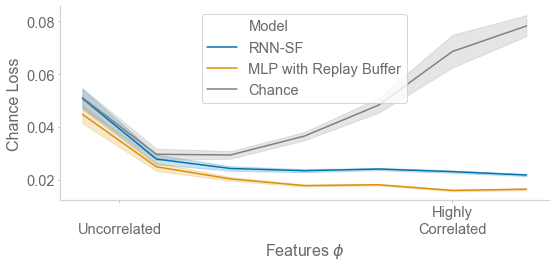

In [9]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(
    x='Sigma', y='Final Loss', hue='Model',
    ax = ax, data=df[(df['Gamma']==0.75)],
    hue_order=hue_order
    )
sns.lineplot(
    x='Sigma', y='Chance Loss',
    ax = ax, data=df[(df['Gamma']==0.75) & (df['Model']=='RNN-SF')],
    color='Gray', label='Chance'
    )
plt.xticks([0.5, np.unique(sigmas).size-2], ['\nUncorrelated', 'Highly\nCorrelated'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_corrlineplot.png', dpi=300)

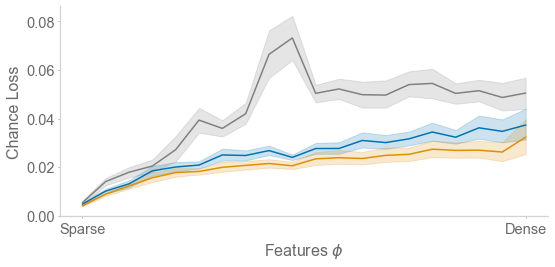

In [10]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(
    x='Sparsity', y='Final Loss', hue='Model',
    ax = ax, data=df[df['Gamma']==0.75],
    hue_order=hue_order, legend=None
    )
sns.lineplot(
    x='Sparsity', y='Chance Loss',
    ax = ax, data=df[(df['Gamma']==0.75) & (df['Model']=='RNN-SF')],
    color='Gray', label='Chance', legend=None
    )
xtick1 = df['Sparsity'].min()
xtick2 = df['Sparsity'].max()
plt.xticks([xtick1, xtick2], ['Sparse', 'Dense'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_sparselineplot.png', dpi=300)

# Make 2D plots

In [11]:
np.unique(models)

array(['Linear', 'MLP with Replay Buffer', 'RNN-Oja', 'RNN-SF'],
      dtype='<U22')

In [12]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

In [13]:
def get_edge_nans(im):
    """ im is processed row-by-row (e.g., sigma by sparsity) """
    
    mask = np.zeros(im.shape).astype(bool)
    nrows, ncols = im.shape
    for i in range(nrows):
        j = 0
        while np.isnan(im[i,j]) and (j < ncols):
            mask[i,j] = True
            j += 1
    return mask

In [14]:
plt.rcParams.update({'hatch.color': 'darkgray'})

In [15]:
def make_gradients(
    xs, ys, zs, models, cmap="Reds",
    plottype='RNN-SF', chance_relative=False, chance_zs=None,
    title=None, xlabel=None, ylabel=None,
    figname=None, figsize=[6.4, 4.8],
    interpolate=False, smooth=False, contours=None,
    leave_edge_nans=True, xlim=None
    ):
    
    # Collect data into a meshgrid
    xs = xs.astype(float)
    ys = ys.astype(float)
    zs = zs.astype(float)
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dxs = np.around(x_list[1:] - x_list[:-1], decimals=2)
    dys = np.around(y_list[1:] - y_list[:-1], decimals=2)
    if np.unique(dxs).size > 1 or np.unique(dys).size > 1:
        if smooth:
            print("Warning: Smoothing with inconsistent dx/dy")
    x_list = np.concatenate((x_list, [x_list[-1]+dxs[-1]]))
    y_list = np.concatenate((y_list, [y_list[-1]+dys[-1]]))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            ij_idx = np.logical_and(
                np.logical_and(xs==x[i,j], ys==y[i,j]),
                models==plottype
                )
            _val = np.nanmean(zs[ij_idx])
            if chance_relative:
                _chance_val = np.nanmean(chance_zs[ij_idx])
                val = _chance_val/_val
            else:
                val = _val
            z[i,j] = val
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('yellow')
    
    # Plot raw grid values
    fig, ax = plt.subplots()
    im = ax.pcolormesh(
        x, y, z, cmap=cmap
        )
    fig.colorbar(im, ax=ax)
    plt.show()
    
    # Remove padding used for pcolormesh plot
    x = x[:-1,:-1]
    y = y[:-1,:-1]
    z = z[:-1,:-1]
            
        
    # Mark NaNs
    nan_mask = np.isnan(z)
    edge_nan_mask = get_edge_nans(z)

    # Interpolate to fill in NaN cells
    if interpolate:
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals

    # Smooth over cells to denoise
    if smooth:
        from astropy.convolution import Gaussian2DKernel
        from astropy.convolution import convolve
        kernel = Gaussian2DKernel(x_stddev=1, y_stddev=1)
        z = convolve(z, kernel, preserve_nan=True)
    
    # Generate contour plots
    levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots(figsize=figsize)

    cf = ax.contourf(x, y, z,
                     levels=levels, cmap=cmap
                     )
    if leave_edge_nans: # White out parts that were extrapolated
        nans = np.argwhere(edge_nan_mask)
        nan1 = nans[0]; nan2 = nans[-1]
        nan1x = x[nan1[0],nan1[1]]
        nan1y = y[nan1[0],nan1[1]]
        nan2x = x[nan2[0],nan2[1]]
        nan2y = y[nan2[0],nan2[1]]
        max_y = y.max()
        plt.fill(
            [nan1x, nan2x, nan1x],
            [nan1y, nan2y, max_y],
            color='white'
            )
    if xlim is not None: # Adjust x limits
        plt.xlim(xlim)
    if contours is not None: # Draw contours
        cntrs = plt.contourf(
            x, y, z, contours,
            hatches='//', alpha=0.01,
            colors='white'
            )
        plt.clabel(cntrs, inline=True, fontsize=12)
    fig.colorbar(cf, ax=ax)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()
    
    return x, y, z

In [16]:
_gamma = 0.75

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

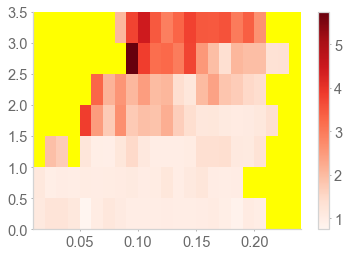

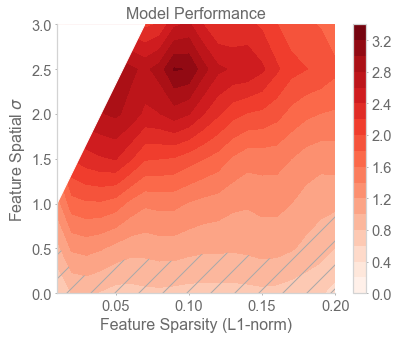

In [17]:
# RNN-SF
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_rnn_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-SF', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

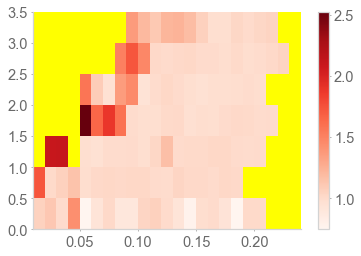

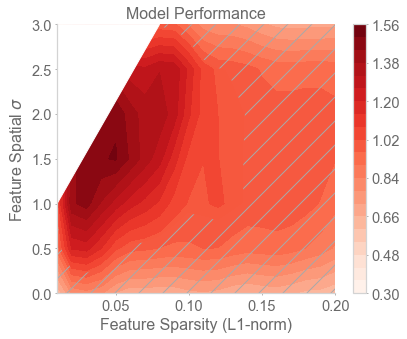

In [18]:
# RNN-Oja
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_rnn_oja_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-Oja', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

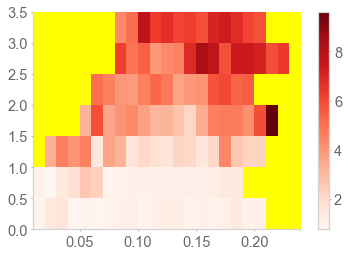

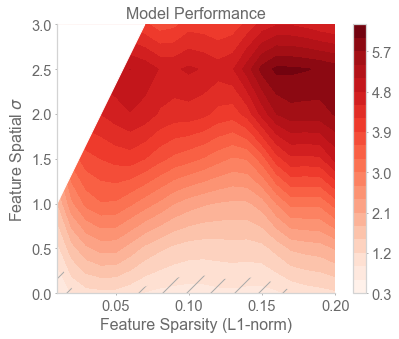

In [19]:
# Linear
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_linear_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='Linear', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )

## Loss as a function of gamma

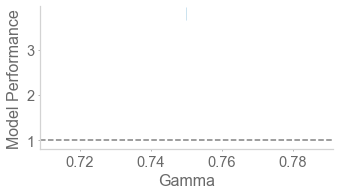

In [20]:
fig, ax = plt.subplots(figsize=(5,3))
sns.lineplot(
    x='Gamma', y='Fold Improvement from Chance',
    hue='Model',
    ax = ax,
    data=df[df['Model'] == 'Linear'],
    legend=None
    )
ax.set_ylim(0.8)
ax.axhline(1.0, color='gray', linestyle='--')
ax.set_ylabel('Model Performance')
plt.tight_layout()
plt.savefig('4a_gamma_perf.png', dpi=300)